In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image

In [2]:
df = pd.read_csv("../../../data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df["waterfront"].fillna("0", inplace = True)
df["view"].fillna("0", inplace = True)
df["yr_renovated"].fillna("0", inplace = True)

# I noticed that using the above code changed the columns to objects and so they weren't showing up in the df.describe() below.
df["waterfront"] = df["waterfront"].astype("float64")
df["view"] = df["view"].astype("float64")
df["yr_renovated"] = df["yr_renovated"].astype("float64")

# later noticed that sqft_basement was an object instead of float so I'm going to change that as well
# sqft_basement has  454 ? as a placeholder value, so we're going to replace that with 0 (which is already over half of values)
df["sqft_basement"] = df["sqft_basement"].replace("?", "0")
df["sqft_basement"] = df["sqft_basement"].astype("float64")

# changing date from an object to a datetime
df["date"] = df["date"].astype("datetime64")

# feature engineering a month sold and year sold column from date
df["year_sold"] = pd.DatetimeIndex(df['date']).year
df["year_sold"] = df["year_sold"].astype("int32")

df["month_sold"] = pd.DatetimeIndex(df["date"]).month
df["month_sold"] = df["month_sold"].astype("int32")

In [4]:
df = df[(np.abs(stats.zscore(df["price"])) < 3)]

In [5]:
X = df[["sqft_living", "sqft_living15", "bathrooms"]]
X["grade_sq"] = df["grade"]**4

y = df[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, random_state=42)

<ipython-input-5-78d8840b3bfe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["grade_sq"] = df["grade"]**4


In [6]:
model = LinearRegression()
model.fit(X_train2, y_train2)

predict_train = model.predict(X_train2)
predict_test = model.predict(X_test2)

print('Training r2:', (r2_score(y_train2, predict_train)))
print('Test r2:', (r2_score(y_test2, predict_test)))
print("RMSE: ", (np.sqrt(mean_squared_error(y_test2, predict_test))))

Training r2: 0.520705522951065
Test r2: 0.5375724227733399
RMSE:  176247.62352309376


In [7]:
X = df[["sqft_living", "sqft_living15", "bathrooms", "yr_built", "lat", "condition", "view", "month_sold",
        "long", "zipcode", "waterfront", "year_sold"]]
X["grade_sq"] = df["grade"]**4

y = df[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, random_state=42)


model.fit(X_train2, y_train2)

predict_train = model.predict(X_train2)
predict_test = model.predict(X_test2)

print('Training r2:', (r2_score(y_train2, predict_train)))
print('Test r2:', (r2_score(y_test2, predict_test)))
print("RMSE: ", (np.sqrt(mean_squared_error(y_test2, predict_test))))

Training r2: 0.7047923949638291
Test r2: 0.7194794235517776
RMSE:  137272.57117663807


<ipython-input-7-67461c1cfb44>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["grade_sq"] = df["grade"]**4


In [8]:
poly = PolynomialFeatures(include_bias=False)

poly_train = poly.fit_transform(X_train2)
poly_test = poly.fit_transform(X_test2)

polymodel = LinearRegression()

polymodel.fit(poly_train, y_train2)

polypredict = polymodel.predict(poly_test)
print(r2_score(y_test2, polypredict))
print("RMSE: ", (np.sqrt(mean_squared_error(y_test2, polypredict))))

0.7779306403549986
RMSE:  122136.57215831935


In [9]:
final_test = poly.fit_transform(X_test)

final_predict = polymodel.predict(final_test)

print("R-squared: ", (r2_score(y_test, final_predict)))
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, final_predict))))

R-squared:  0.7815890410674926
RMSE:  122312.00540020148


In [61]:
sampleX = X_train2[["condition", "view"]].sample(n=200, random_state=42)
sampley = y_train2['price'].sample(n=200, random_state=42)

temp_X = sampleX.values.reshape(-1,2)
temp_y = sampley

x = temp_X[:, 0]
y = temp_X[:, 1]
z = temp_y

x_pred = np.linspace(380, 7480, 30)   # range of porosity values
y_pred = np.linspace(399, 5790, 30)  # range of brittleness values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

In [62]:
graph_model = LinearRegression().fit(temp_X, temp_y)
graph_pred = graph_model.predict(model_viz)
r2 = graph_model.score(temp_X, temp_y)

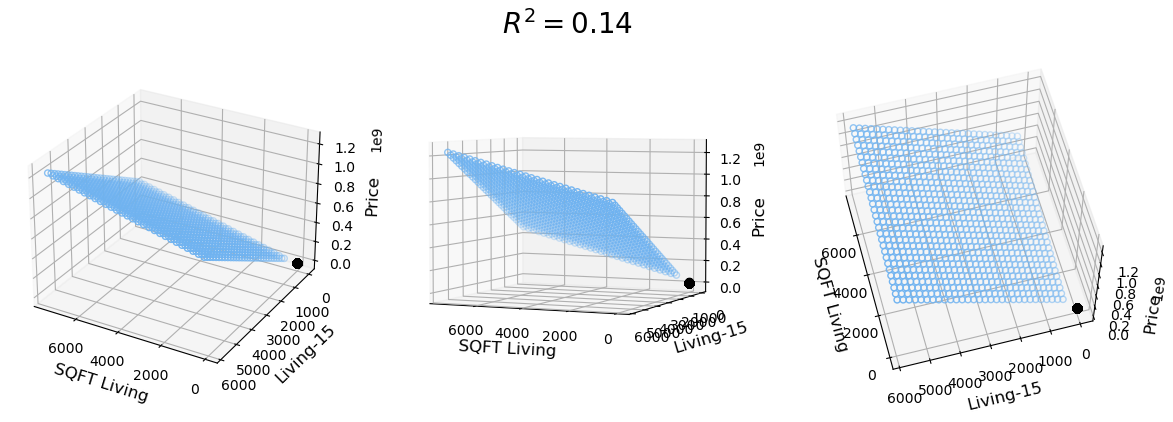

In [63]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), graph_pred, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('SQFT Living', fontsize=12)
    ax.set_ylabel('Living-15', fontsize=12)
    ax.set_zlabel('Price', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
    
ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

(1000.0, 1000000.0)

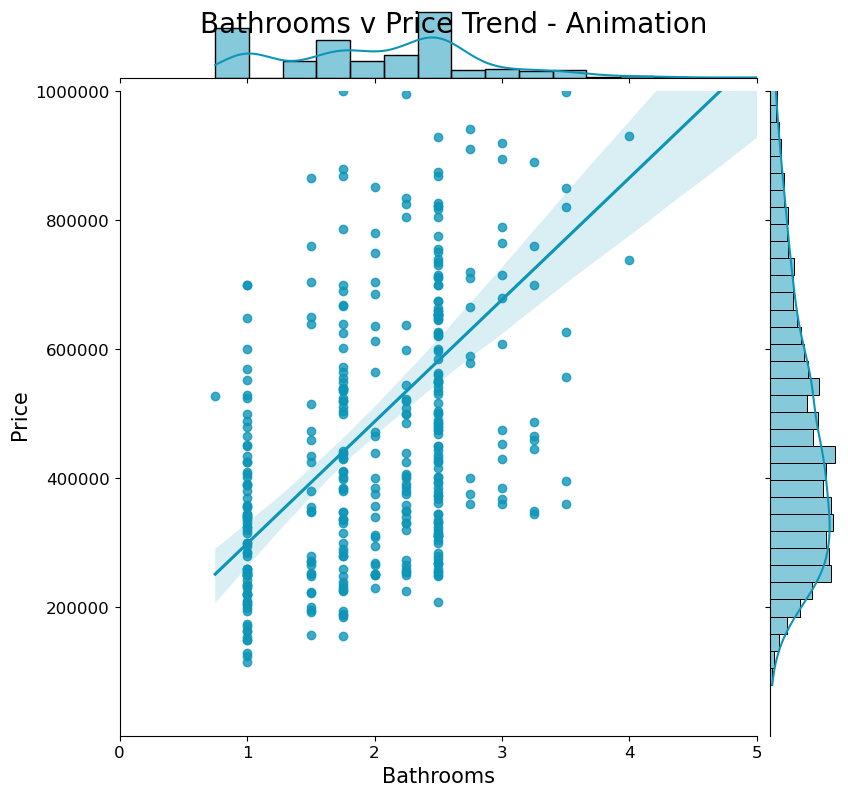

In [108]:
sns.jointplot(x= X_train2["bathrooms"].sample(n=400, random_state=42), y=y_train2['price'],
              kind="reg", color="#0D95B8", height=8, ratio=8)
plt.suptitle("Bathrooms v Price Trend - Animation", fontsize=20)
plt.xlabel("Bathrooms", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.tick_params(labelsize=12)
plt.ticklabel_format(style='plain')
plt.xlim(0,5)
plt.ylim(1000,1000000)


(1000.0, 1000000.0)

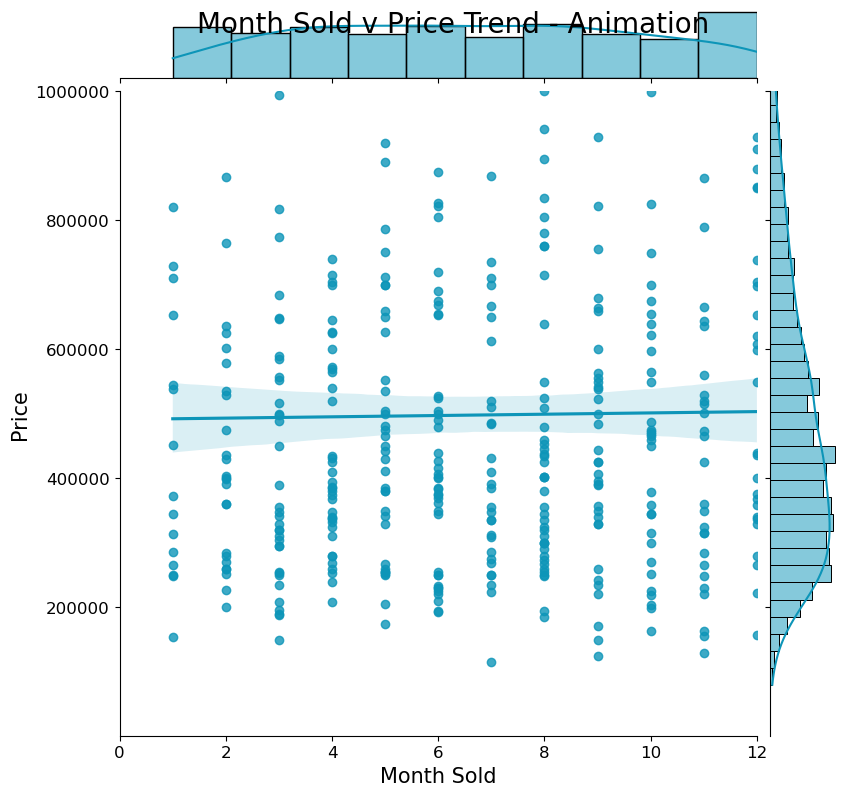

In [107]:
sns.jointplot(x= X_train2["month_sold"].sample(n=400, random_state=42), y=y_train2['price'],
              kind="reg", color="#0D95B8", height=8, ratio=8)
plt.suptitle("Month Sold v Price Trend - Animation", fontsize=20)
plt.xlabel("Month Sold", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.tick_params(labelsize=12)
plt.ticklabel_format(style='plain')
plt.xlim(0,12)
plt.ylim(1000,1000000)

(0.0, 1000000.0)

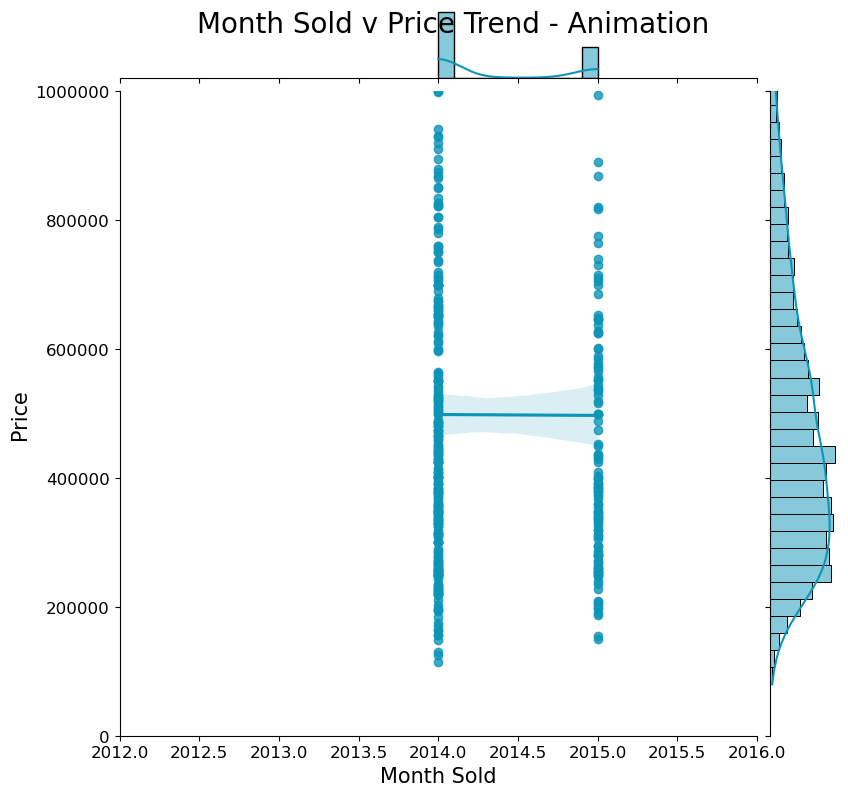

In [106]:
sns.jointplot(x= X_train2["year_sold"].sample(n=400, random_state=42), y=y_train2['price'],
              kind="reg", color="#0D95B8", height=8, ratio=8)
plt.suptitle("Month Sold v Price Trend - Animation", fontsize=20)
plt.xlabel("Month Sold", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.tick_params(labelsize=12)
plt.ticklabel_format(style='plain')
plt.xlim(2012,2016)
plt.ylim(0,1000000)

(0.0, 1000000.0)

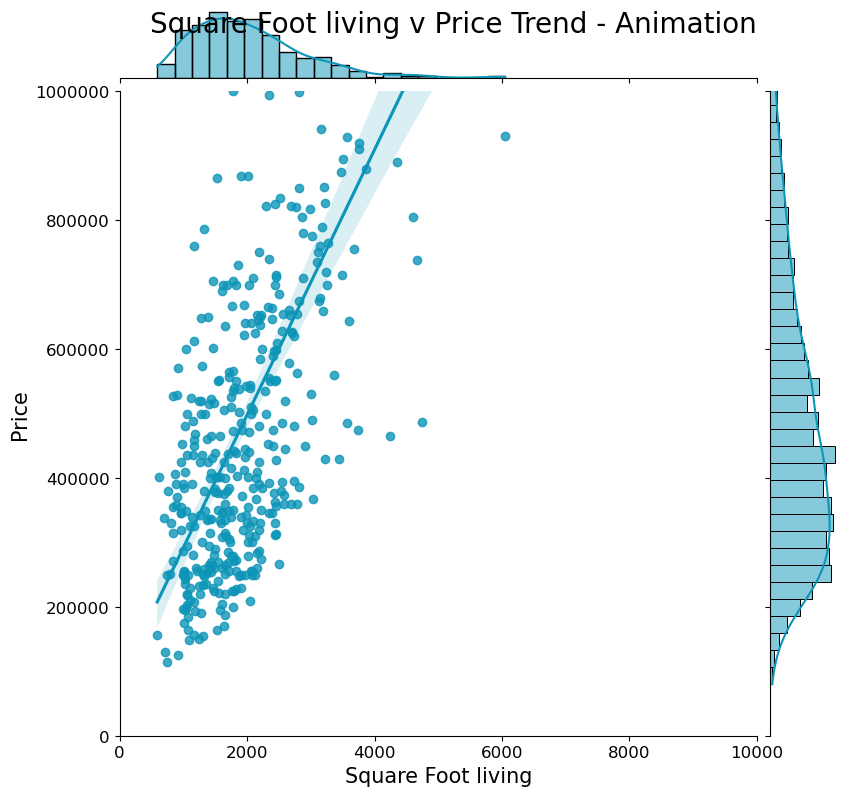

In [105]:
sns.jointplot(x= X_train2["sqft_living"].sample(n=400, random_state=42), y=y_train2['price'],
              kind="reg", color="#0D95B8", height=8, ratio=8)
plt.suptitle("Square Foot living v Price Trend - Animation", fontsize=20)
plt.xlabel("Square Foot living", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.tick_params(labelsize=12)
plt.ticklabel_format(style='plain')
plt.xlim(0,10000)
plt.ylim(0,1000000)

(0.0, 1000000.0)

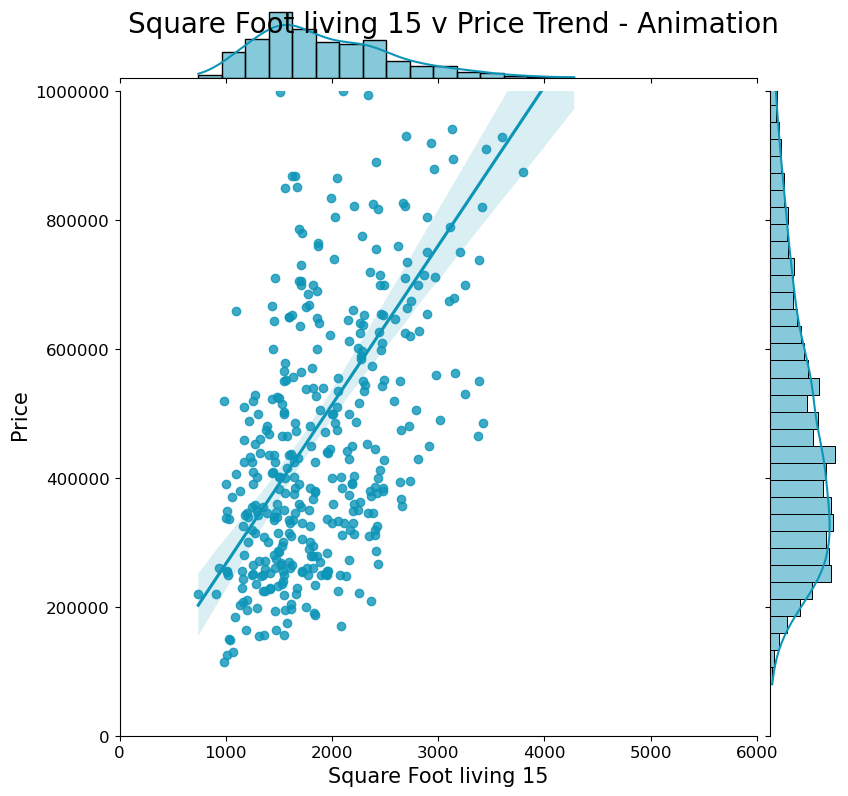

In [114]:
sns.jointplot(x= X_train2["sqft_living15"].sample(n=400, random_state=42), y=y_train2['price'],
              kind="reg", color="#0D95B8", height=8, ratio=8)
plt.suptitle("Square Foot living 15 v Price Trend - Animation", fontsize=20)
plt.xlabel("Square Foot living 15", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.tick_params(labelsize=12)
plt.ticklabel_format(style='plain')
plt.xlim(0,6000)
plt.ylim(0,1000000)